In [1]:
import wget
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
#filename = wget.download(url)

In [2]:
filename = './1eei (1).pdb'

In [3]:
import torch_geometric

In [4]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as L

# PyTorch

import torch
import scipy.sparse
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric

from torch_geometric.data import Data, Dataset
from torch_geometric.data import HeteroData

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V'],
      dtype='object')
566
    0     1     2     3     4     5     6      7      8      9    ...   556  \
A  4.35  0.61  1.18  1.56  1.00  0.77  0.37  0.357   52.6   16.0  ...   6.0   
R  4.38  0.60  0.20  0.45  0.52  0.72  0.84  0.529  109.1  -70.0  ...  19.0   
N  4.75  0.06  0.23  0.27  0.35  0.55  0.97  0.463   75.7  -74.0  ...  12.0   
D  4.76  0.46  0.05  0.14  0.44  0.65  0.97  0.511   68.4  -78.0  ...  12.0   
C  4.65  1.07  1.89  1.23  0.06  0.65  0.84  0.346   68.3  168.0  ...   6.0   
Q  4.37  0.00  0.72  0.51  0.44  0.72  0.64  0.493   89.7  -73.0  ...  12.0   
E  4.29  0.47  0.11  0.23  0.73  0.55  0.53  0.497   84.7 -106.0  ...  12.0   
G  3.97  0.07  0.49  0.62  0.35  0.65  0.97  0.544   36.3  -13.0  ...   1.0   
H  4.63  0.61  0.31  0.29  0.60  0.83  0.75  0.323   91.9   50.0  ...  15.0   
I  3.95  2.22  1.45  1.67  0.73  0.98  0.37  0.462  102.0  151.0  ...

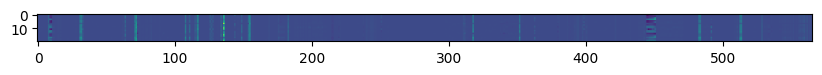

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

aaproperties = pd.read_csv('./aaindex1.csv', header=0)
aaproperties.drop( [ 'description' , 'reference'  ], axis=1, inplace=True)

print(aaproperties.columns)
print( len(aaproperties) )

#one hot encoding
onehot= np.fill_diagonal(np.zeros((20,20)), 1)
onehot = pd.DataFrame(onehot)
#change to integers instead of bool
onehot = onehot.astype(int)
#append to the dataframe
aaproperties = aaproperties.T
aaproperties = pd.concat([aaproperties, onehot ], axis=1)
aaproperties[aaproperties.isna() == True] = 0
print(aaproperties)

plt.figure( figsize=(10,10) )
plt.imshow(aaproperties)


In [17]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pydssp
from Bio.PDB import PDBParser   
import numpy as np
filename = './1eei.pdb'

def read_pdb(filename):
    #silence all warnings
    warnings.filterwarnings('ignore')

    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+3] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    #translate to single letter code


    residue = chain[0]
    residue_id = residue.get_full_id()

    phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": 0,
            "Psi_Angle": 0
        })


    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)
        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": phi,
            "Psi_Angle": psi
        })

    residue = chain[-1]
    residue_id = residue.get_full_id()

    phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": 0,
            "Psi_Angle": 0
        })
    
    #transform phi and psi angles into a dataframe
    phi_psi_angles = pd.DataFrame(phi_psi_angles)
    #transform the residue names into single letter code
    return phi_psi_angles    

def get_contact_points(chain, distance=25):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat


def get_closest(chain):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            contact_mat[i,j] =  r1['CA'] - r2['CA']
    #go through each row and select min
    for r in contact_mat.shape[0]:
        contact_mat[r, :][ contact_mat[r, :] != np.amin(contact_mat)] =  0
    return contact_mat


def get_backbone(chain):
    contact_mat = np.zeros((len(chain), len(chain)))
    #fill diagonal with 1s
    np.fill_diagonal(contact_mat, 1)
    return contact_mat

def ret_hbonds(chain , verbose = False):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)

    #N,CA,C,O
    typeindex = {'N':0, 'CA':1 , 'C':2, 'O':3}
    #get the number of atoms in the chain
    #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
    output = np.zeros((1, len(chain), len(typeindex), 3 ))
    for c, res in enumerate(chain):
        atoms = res.get_atoms()
        for at,atom in enumerate(atoms):
            if atom.get_name() in typeindex:
                output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
    output = torch.tensor(output)
    if verbose:
        print(output.shape)
    mat =  pydssp.get_hbond_map(output[0])
    return mat

#add the amino acid properties to the angles dataframe
#one hot encode the amino acid properties
def add_aaproperties(angles, aaproperties = aaproperties , verbose = False):
    if verbose == True:
        print(aaproperties , angles )
    nodeprops = angles.merge(aaproperties, left_on='single_letter_code', right_index=True, how='left')
    nodeprops = nodeprops.dropna()

    #generate 1 hot encoding for each amino acid
    #one_hot = pd.get_dummies(nodeprops['single_letter_code']).astype(int)
    #nodeprops = nodeprops.join(one_hot)
    #nodeprops = nodeprops.drop(columns=['single_letter_code'])
    return nodeprops

@> 4630 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> Hessian was built in 0.17s.
@> 20 modes were calculated in 0.10s.


(1545, 1545)


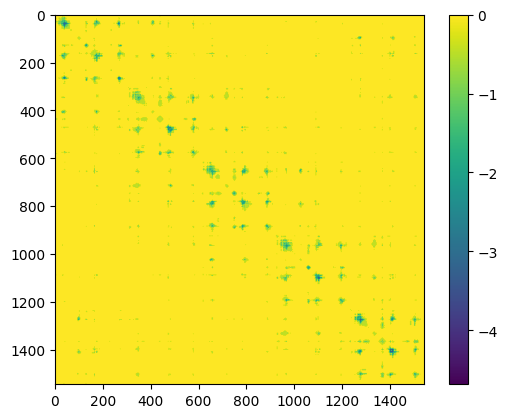

0.005025495886680457
11936


In [18]:
from prody import *
from pylab import *
import warnings
def anm_analysis(filename):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prot = parsePDB( filename  , )
        calphas2 = prot.select('calpha')
        anm = ANM('ANM analysis')
        anm.buildHessian(calphas2)
        anm.calcModes()
        cov = anm.getCovariance()
        cov[ cov < 0] = -cov[ cov < 0]
        logcov = np.log(cov)
        #get the top .5% of the covariance matrix
        top = np.percentile(logcov, 99.5)
        logcov[ logcov < top] = 0
        
        
        return logcov

cov = anm_analysis(filename)
print(cov.shape)

plt.imshow(cov)
plt.colorbar()
plt.show()

#print the number of 0 entries
print( np.sum(cov != 0) /np.sum(cov == 0))
print( np.sum(cov != 0) )

In [19]:
#create features from a monomer pdb file
from scipy import sparse
from copy import deepcopy

def create_features(monomerpdb, aaproperties, distance = 8, verbose = False):
    chain = read_pdb(monomerpdb)[0]
    chain = [ r for r in chain if PDB.is_aa(r)]
    angles = get_angles(chain)
    if len(angles) ==0:
        return None
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.dropna()
    angles = angles.reset_index(drop=True)
    angles = angles.set_index(['Chain', 'Residue_Number'])
    angles = angles.sort_index()
    angles = angles.reset_index()
    angles = angles.drop(['Chain', 'Residue_Number' , 'Residue_Name'], axis=1)
    vals = deepcopy(angles)
    vals = vals.dropna()
    vals = vals.drop( ['single_letter_code'] , axis = 1 )
    vals = vals.values
    vals = vals.astype('float32')
    if verbose:
        print('vals',vals.shape)   
        plt.imshow(vals)
        plt.colorbar()
        plt.show()

    contact_points = get_contact_points(chain, distance)
    if verbose:
        print('contacts' , contact_points.shape)
        plt.imshow(contact_points)
        plt.colorbar()
        plt.show()
    hbond_mat = np.array(ret_hbonds(chain, verbose))
    if verbose:
        print('hbond' , hbond_mat.shape)
        plt.imshow(hbond_mat)
        plt.colorbar()
        plt.show()
    #return the angles, amino acid properties, contact points, and hydrogen bonds
    #backbone is just the amino acid chain
    backbone = get_backbone(chain)
    #springmat = anm_analysis(monomerpdb)
    """if verbose:
        print('spring' , springmat.shape)
        plt.imshow(springmat)
        plt.colorbar()
        plt.show()"""
    #change the contac matrices to sparse matrices
    contact_points = sparse.csr_matrix(contact_points)
    #springmat = sparse.csr_matrix(springmat)
    backbone = sparse.csr_matrix(backbone)
    hbond_mat = sparse.csr_matrix(hbond_mat)

    return angles, contact_points, 0 , hbond_mat, backbone


vals (103, 568)


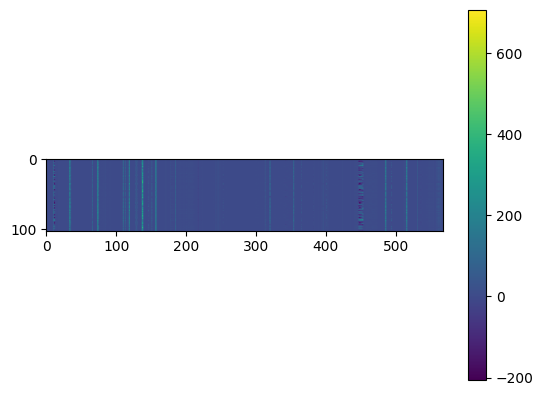

contacts (103, 103)


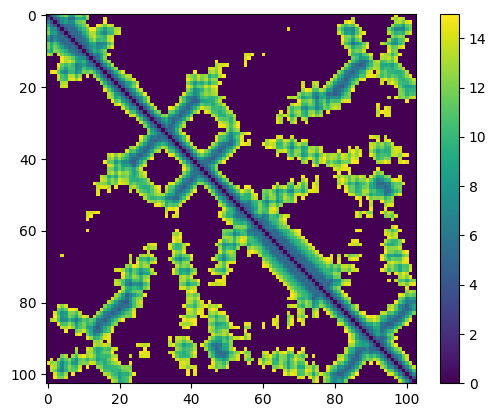

torch.Size([1, 103, 4, 3])
hbond (103, 103)


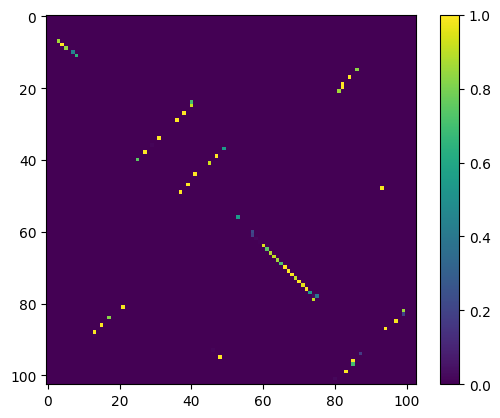

(    single_letter_code  Phi_Angle  Psi_Angle     0     1     2     3     4  \
 0                    T   0.000000   0.000000  4.35  0.05  0.84  0.91  0.44   
 1                    T  -1.047017   2.663062  4.35  0.05  0.84  0.91  0.44   
 2                    P  -1.903192  -0.014165  4.44  1.95  0.76  0.76  0.06   
 3                    Q  -2.789905   2.943459  4.37  0.00  0.72  0.51  0.44   
 4                    N  -1.061407  -0.663699  4.75  0.06  0.23  0.27  0.35   
 ..                 ...        ...        ...   ...   ...   ...   ...   ...   
 98                   A  -2.461680   2.534450  4.35  0.61  1.18  1.56  1.00   
 99                   I  -2.263589   2.385299  3.95  2.22  1.45  1.67  0.73   
 100                  S  -2.224691   2.443919  4.50  0.05  0.97  0.81  0.35   
 101                  M  -2.760119   2.508907  4.52  1.18  2.67  2.96  1.00   
 102                  N   0.000000   0.000000  4.75  0.06  0.23  0.27  0.35   
 
         5     6  ...   556     557   558   559   

In [22]:
create_features(filename, aaproperties, distance = 15, verbose = True)

In [23]:

#write a function to store sparse matrices in an hdf5 file for many pdb files
import h5py
def store_features( pdbfiles, aaproperties, filename, verbose = False):
    #create a hdf5 file
    with h5py.File(filename, 'pdbfiles') as f:
        for pdbfile in pdbfiles:
            if verbose:
                print(pdbfile)
            angles, contact_points, springmat, backbone = create_features(pdbfile, aaproperties, verbose)
            #store the features in the hdf5 file
            f.create_dataset(pdbfile + '_angles', data=angles)
            f.create_dataset(pdbfile + '_contact_points', data=contact_points)
            f.create_dataset(pdbfile + '_springmat', data=springmat)
            f.create_dataset(pdbfile + '_backbone', data=backbone)

In [24]:
import pandas as pd
cols = 'repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId'.split('_')
repdf = pd.read_table( './afdbclusters/2-repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId.tsv')
repdf.columns = cols
print(repdf.head())

        repId  isDark  nMem  repLen   avgLen  repPlddt  avgPlddt  LCAtaxId
0  A0A6M1CKG1       0     3     122  122.667     96.06   88.1467     91347
1  A0A4Q3Q6P1       1     3     117  113.333     71.94   67.8333     80864
2  A0A4V3EFQ4       0     3     153  156.000     68.56   58.8533    131567
3  A0A4V3EKB1       1     3      51   51.000     62.62   62.7700      1883
4  A0A4V3EP89       0     2      96   94.500     70.88   72.1900   2593676


In [25]:
import multiprocessing as mp
import tqdm
import os
import numpy as np
import wget 

def download_pdb(rep ,structdir = './structs/'):
    url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
    #check if file exists
    if os.path.exists( structdir + rep + '.pdb'):
        return self.raw_dir + rep + '.pdb'
    filename = wget.download(url, out=structdir + rep + '.pdb')
    return filename

def download(repdf , nreps = 100 , structdir = './structs/'):
    if not os.path.exists(structdir):
        os.makedirs(structdir)
            
    reps = repdf.repId.unique()
    if nreps:
        #select a random sample of representatives
        reps = np.random.choice(reps, nreps)
    with mp.Pool(20) as p:
        filenames = p.map(download_pdb, tqdm.tqdm(reps))
    return filenames

In [26]:

#download(repdf, nreps = 100 , structdir = './structs/' )


In [27]:


AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

#create the h5 dataset from the pdb files
import glob
import h5py

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [28]:

def sparse2pairs(sparsemat):
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])


metadata = { 'edge_types': [ ('res','backbone','res') , ('res','contactPoints', 'res') , ('res','hbond', 'res') ] }


def struct2pyg(pdbchain , aaproperties= aaproperties):
    data = HeteroData()
    #transform a structure chain into a pytorch geometric graph
    #get the adjacency matrices
    
    xdata = create_features(pdbchain, aaproperties)
    if data is not None:
        angles, contact_points, springmat , hbond_mat , backbone = xdata
    else:
        return None
    if len(angles) ==0 :
        return None    
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.drop(['single_letter_code'], axis=1)    
    angles.fillna(0, inplace=True)
    angles = torch.tensor(angles.values, dtype=torch.float32)
    data['res'].x = angles

    #get the edge features
    data['res','backbone','res'].edge_attr = torch.tensor(backbone.data, dtype=torch.float32)
    data['res','contactPoints', 'res'].edge_attr = torch.tensor(contact_points.data, dtype=torch.float32)
    data['res','hbond', 'res'].edge_attr = torch.tensor(hbond_mat.data, dtype=torch.float)
    #data['res','springMat', 'res'].edge_attr = torch.tensor(springmat.data, dtype=torch.float32)

    backbone = sparse2pairs(backbone)
    contact_points = sparse2pairs(contact_points)
    hbond_mat = sparse2pairs(hbond_mat)
    springmat = sparse2pairs(springmat)
    
    #get the adjacency matrices into tensors
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','contactPoints', 'res'].edge_index = torch.tensor(contact_points,  dtype=torch.long )    
    data['res','hbond', 'res'].edge_index = torch.tensor(hbond_mat,  dtype=torch.long )
    #data['res','springMat', 'res'].edge_index = torch.tensor(springmat,  dtype=torch.long )
    

    #add self loops
    data['res','backbone','res'].edge_index = torch_geometric.utils.add_self_loops(data['res','backbone','res'].edge_index)[0]
    #data['res','contactPoints', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','contactPoints', 'res'].edge_index)[0]
    #data['res','hbond_mat', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','hbond_mat', 'res'].edge_index)[0]

    #normalize features

    #data['res'].x = torch_geometric.transforms.NormalizeFeatures(data['res'].x)
    #data['res','contact_points', 'res'].edge_attr = torch_geometric.transforms.normalize_edge_attr(data['res','contact_points', 'res'].edge_attr)
    #data['res','spring_mat', 'res'].edge_index = torch_geometric.transforms.normalize_edge_attr(data['res','spring_mat', 'res'].edge_attr)
    #data['res','hbond_mat', 'res'].edge_attr = torch_geometric.transforms.normalize_edge_attr(data['res','hbond_mat', 'res'].edge_attr)

    return data

#create a function to store the pytorch geometric data in a hdf5 file
def store_pyg(pdbfiles, aaproperties, filename, verbose = True):
    with h5py.File(filename , mode = 'w') as f:
        for pdbfile in tqdm.tqdm(pdbfiles):
            if verbose:
                print(pdbfile)
            hetero_data = struct2pyg(pdbfile, aaproperties)
            if hetero_data:
                f.create_group(pdbfile)

                for node_type in hetero_data.node_types:
                    if hetero_data[node_type].x is not None:
                        node_group = f.create_group(f'{pdbfile}/node/{node_type}')
                        node_group.create_dataset('x', data=hetero_data[node_type].x.numpy())
                        
                # Iterate over edge types and their connections
                for edge_type in hetero_data.edge_types:
                    # edge_type is a tuple: (src_node_type, relation_type, dst_node_type)
                    edge_group = f.create_group(f'{pdbfile}/edge/{edge_type[0]}_{edge_type[1]}_{edge_type[2]}')
                    if hetero_data[edge_type].edge_index is not None:
                        edge_group.create_dataset('edge_index', data=hetero_data[edge_type].edge_index.numpy())
                    
                    # If there are edge features, save them too
                    if hasattr(hetero_data[edge_type], 'edge_attr') and hetero_data[edge_type].edge_attr is not None:
                        edge_group.create_dataset('edge_attr', data=hetero_data[edge_type].edge_attr.numpy())


                    #todo. store some other data. sequence. uniprot info etc.
            else:
                print('err' , pdbfile )
    

In [29]:
pdbfiles = glob.glob('./structs/*.pdb')
store_pyg(pdbfiles, aaproperties, filename='structs.h5', verbose = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:32<00:00,  2.04it/s]


In [ ]:
class StructureDataset(Dataset):
    def __init__(self, h5dataset):
        super().__init__()
        #keys should be the structures
        self.structures = h5dataset['structs']
        self.structlist = list(self.structures.keys())
        
    def __len__(self):
        return len(self.structures)

    def __getitem__(self, idx):
        if type(idx) == str:
            f = self.structures[idx]
        elif type(idx) == int:
            f = self.structures[self.structlist[idx]]
        else:
            raise 'use a structure filename or integer'
        data = {}
        hetero_data = HeteroData()
        if 'node' in f.keys():
            for node_type in f['node'].keys():
                node_group = f['node'][node_type]
                # Assuming 'x' exists
                if 'x' in node_group.keys():
                    hetero_data[node_type].x = torch.tensor(node_group['x'][:])
        # Edge data
        if 'edge' in f.keys():
            for edge_name in f['edge'].keys():
                edge_group = f['edge'][edge_name]
                src_type, link_type, dst_type = edge_name.split('_')
                edge_type = (src_type, link_type, dst_type)
                # Assuming 'edge_index' exists
                if 'edge_index' in edge_group.keys():
                    hetero_data[edge_type].edge_index = torch.tensor(edge_group['edge_index'][:])
                
                # If there are edge attributes, load them too
                if 'edge_attr' in edge_group.keys():
                    hetero_data[edge_type].edge_attr = torch.tensor(edge_group['edge_attr'][:])
        #return pytorch geometric heterograph
        return hetero_data
        


In [44]:
import time
import h5py
f = h5py.File('./structs.h5' , 'r')
struct_dat = StructureDataset(f)
print( len(struct_dat) )
start = time.time()
print( struct_dat[10] )
print( time.time()-start)

start = time.time()
ndim = struct_dat[20]['res'].x.shape[1]
print( time.time()-start)

800
HeteroData(
  res={ x=[115, 1134] },
  (res, backbone, res)={
    edge_index=[2, 230],
    edge_attr=[115],
  },
  (res, contactPoints, res)={
    edge_index=[2, 1116],
    edge_attr=[1116],
  },
  (res, hbond, res)={
    edge_index=[2, 64],
    edge_attr=[64],
  }
)
0.009657144546508789
0.0025055408477783203


In [45]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData



import networkx as nx
from torch_geometric.data import HeteroData



def remove_self_loops_edge_index(edge_index):
    """
    Removes self-loops from the edge_index of a graph.
    """
    mask = edge_index[0] != edge_index[1]
    return edge_index[:, mask]

def convert_hetero_to_networkx(hetero_data):
    G = nx.MultiDiGraph()  # Use MultiDiGraph to support multiple edge types
    # Add nodes with type as an attribute
    for node_type in hetero_data.node_types:
        for node_id in range(hetero_data[node_type].num_nodes):
            # Node identifier format: (node_type, node_id)
            G.add_node((node_type, node_id), node_type=node_type)
    # Add edges
    for edge_type in hetero_data.edge_types:
        src_type, _, dst_type = edge_type
        edge_indices = hetero_data[edge_type].edge_index
        edge_indices = remove_self_loops_edge_index(edge_indices)
        for i in range(edge_indices.shape[1]):  # Iterate through each edge
            src_id, dst_id = edge_indices[:, i].tolist()
            # Edge identifier format: ((src_type, src_id), (dst_type, dst_id))
            G.add_edge((src_type, src_id), (dst_type, dst_id), edge_type=edge_type)

    return G

def plot_hetero_graph_with_curved_edges(data):
    print(data)
    G = convert_hetero_to_networkx(data)
    print(G)
    pos = nx.spring_layout(G)  # General layout if no positions are provided

    # Calculate offset for curved edges to avoid overlap
    edge_count = {}
    for src, dst, key in G.edges(keys=True):
        edge_count[(src, dst)] = edge_count.get((src, dst), 0) + 1
    # Draw nodes
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=70)
    
    edge_type_colors = {}
    unique_edge_types = data.edge_types
    # Generate a color map from matplotlib, or use a predefined set of colors
    colors = plt.get_cmap('tab20')(range(len(unique_edge_types)))
    for i, edge_type in enumerate(unique_edge_types):
        edge_type_colors[edge_type] = colors[i]

    # Draw edges with curvature
    for (src, dst), count in edge_count.items():
        for i in range(count):
            edge_key = list(G[src][dst])[i]
            style = G[src][dst][edge_key]
            curvature = 0.1 * (i - count // 2)
            nx.draw_networkx_edges(
                G, pos, edgelist=[(src, dst)],
                connectionstyle=f'arc3, rad={curvature}',
                arrowstyle='-|>',
                edge_color = edge_type_colors.get(edge_type, 'black'),  # Default color is black
                width=style.get('weight', 1),
                alpha = .25
            )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    plt.title('Heterogeneous Graph with Curved Edges')
    plt.axis('off')  # Turn off the axis
    plt.show()

In [46]:
#plot_hetero_graph_with_curved_edges(struct_dat[10])

In [57]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#geometric lightning
from torch_geometric.data import DataLoader
from torch_geometric.nn.models import VGAE, GAE
from torch_geometric.data import Data
# Define autoencoder model

import torch
from torch.nn import ModuleDict, Linear
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, GATConv , SAGEConv
from torch_geometric.data import HeteroData

class HeteroVGAE_Encoder(torch.nn.Module):
    def __init__(self, in_channels,hidden_layers = [50,50] ,out_channels= 25, metadata={} , normalize = True):
        super(HeteroVGAE_Encoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.metadata = metadata  # Assumes metadata contains edge types information
        #self.normalize = torch_geometric.transforms.NormalizeFeatures()
        for i,hidden_channels in enumerate(hidden_layers):
            # For simplicity, using the same hidden_channels across layers.
            # Adjust based on your model's specific architecture.
            layer_convs = torch.nn.ModuleDict({
                '_'.join(edge_type): TransformerConv(in_channels if i == 0 else hidden_layers[i-1], hidden_channels)
                for edge_type in metadata['edge_types']
            })
            
            self.convs.append(layer_convs)
        # The output layer for mu and logvar
        self.mus = torch.nn.Linear(hidden_channels, out_channels)
        self.log_vars = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index_dict):
        for layer in self.convs:
            x_agg = []
            for edge_type, conv in layer.items():
                edge_type = tuple(edge_type.split('_'))
                edge_index = edge_index_dict[edge_type]
                x_agg.append(conv(x, edge_index))
            x = torch.stack(x_agg).mean(0)
        
        # Compute mean and log variance
        mu = self.mus(x)
        log_var = self.log_vars(x)
        
        # Optionally, reparameterize if training for variational autoencoder functionality
        #x_reparam = self.reparameterize(mu, log_var)
        
        # Here, you could return mu and log_var if needed, or just the reparameterized version
        return mu, log_var

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

In [58]:
import torch
from torch import nn
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
import torch.nn.functional as F

class HeteroGraphDecoder(nn.Module):
    def __init__(self, hidden_channels, encoder_out_channels, metadata ):
        edge_types = metadata['edge_types']
        super(HeteroGraphDecoder, self).__init__()
        # Assuming all edge types will be processed in a similar manner,
        # we do not necessarily need to create separate modules for each edge type.
        # However, for more complex scenarios, consider tailoring modules for each edge type.
        self.edge_types = edge_types
        self.transform  = torch.nn.ModuleDict()
        self.sigmoid_dict =  torch.nn.ModuleDict()
        for edge_type in self.edge_types:
            self.transform['_'.join(edge_type)] = nn.Linear( encoder_out_channels, hidden_channels )
            self.sigmoid_dict['_'.join(edge_type)] = nn.Sigmoid()

    def forward(self, z , sigmoid= True, **kwargs):
        # Transform the latent space if necessary
        edge_probs = {}
        for edge_type in self.edge_types:
            z_transformed = self.transform['_'.join(edge_type)](z)
            sim_matrix = torch.matmul(z_transformed, z_transformed.t())
            edge_probs[edge_type] = self.sigmoid_dict['_'.join(edge_type)](sim_matrix)

        return edge_probs

In [59]:
in_channels=ndim
hidden_channels=50
out_channels = 25
nlayers=2

encoder = HeteroVGAE_Encoder(in_channels=in_channels,  out_channels=out_channels, metadata=metadata)
decoder = HeteroGraphDecoder(hidden_channels=100 , encoder_out_channels = out_channels , metadata=metadata)

In [60]:
#create pytorch lightning dataloaders
    
from torch_geometric.data import DataLoader
import pytorch_lightning as pl
class StructureDataModule(pl.LightningDataModule):
    def __init__(self, structuredir, batch_size=32):
        super().__init__()
        self.structuredir = structuredir
        self.batch_size = batch_size
        self.dataset = StructureDataset(self.structuredir)

    def setup(self, stage=None):
        #split the dataset into training, validation, and test sets
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [int(0.8*len(self.dataset)), int(0.1*len(self.dataset)), int(0.1*len(self.dataset))])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [61]:
import torch
import pytorch_lightning as pl
from torch_geometric.nn import models
import torch.nn.functional as F
from torch_geometric.utils import (negative_sampling, remove_self_loops, add_self_loops)

class GraphAutoencoder(pl.LightningModule):
    def __init__(self, model_name, in_channels, out_channels, hidden_channels, nlayers, learning_rate, encoder_cls, decoder_cls, metadata):
        super(GraphAutoencoder, self).__init__()
        self.save_hyperparameters()
        self.encoder = HeteroVGAE_Encoder(in_channels=in_channels,hidden_channels=hidden_channels,  out_channels=out_channels, metadata=metadata, nlayers=nlayers)
        self.decoder = HeteroGraphDecoder(hidden_channels, out_channels, metadata['edge_types']) if decoder_cls else None
        self.model = models.VGAE(self.encoder) if self.decoder is None else models.VGAE(self.encoder , self.decoder) 
        self.learning_rate = learning_rate
        self.name = model_name

    def forward(self, x_dict, edge_index_dict):
        return self.model.encode(x_dict, edge_index_dict), self.model.decode(self.model.__mu__, self.model.__logvar__)

    def training_step(self, batch, batch_idx):
        x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict
        z, edge_recon = self.forward(x_dict, edge_index_dict)
        # Reconstruction loss
        loss = self.reconstruction_loss(edge_index_dict, edge_recon)
        # KL divergence loss
        kl_loss = 0.5 / z.size(0) * torch.mean(torch.sum(1 + 2 * self.model.__logvar__ - self.model.__mu__**2 - self.model.__logvar__.exp()**2, dim=1))
        
        total_loss = loss - kl_loss
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return total_loss

    def reconstruction_loss(self, edge_index_dict, edge_recon):
        # Implement the specific reconstruction loss for your graph data
        loss = 0
        for edge_type, edge_index in edge_index_dict.items():
            src, dst = edge_type.split('_')[:2]
            pos_loss = -torch.log(edge_recon[edge_type] + 1e-15).mean()
            neg_edge_index = negative_sampling(edge_index, edge_recon[edge_type].size(0))
            neg_loss = -torch.log(1 - edge_recon[edge_type][neg_edge_index[0], neg_edge_index[1]] + 1e-15).mean()
            loss += pos_loss + neg_loss
        return loss

    def validation_step(self, batch, batch_idx):
        # Similar to training_step, calculate the loss for validation data
        pass

    def test_step(self, batch, batch_idx):
        # Similar to training_step, calculate the loss for test data
        pass

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [62]:
def train_autoencoder(model_name, dataloader, in_channels=ndim , hidden_channels=50, out_channels = 10, nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder , metadata=metadata ,**model_kwargs):
    node_data_loader = dataloader
    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=True,
    )  # 0 because epoch size is 1
    
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphAutoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = GraphAutoencoder(model_name=model_name, in_channels=in_channels, hidden_channels=hidden_channels, out_channels = out_channels , nlayers=nlayers, learning_rate=learning_rate , encoder_cls=encoder, decoder_cls=decoder , metadata=metadata )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = GraphAutoencoder.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result
    

In [63]:
#creat a dataloader
from torch_geometric.data import DataLoader
def create_dataloader(dataset, batch_size=5, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

dataloader = create_dataloader(struct_dat)

In [64]:
#train the model on the dataset
"""
model, result = train_autoencoder( 'autoencoder', dataloader, in_channels=ndim , hidden_channels=100, out_channels = 10 ,  nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder , metadata = metadata )

#save the model
torch.save(model.state_dict(), 'autoencoder.pth')

#load the model
model.load_state_dict(torch.load('autoencoder.pth'))

#evaluate the model
model.eval()
with torch.no_grad():
    for data in dataloader:
        data = data.to(model.device)
        z = model.encode(data.x, data.edge_index)
        #get the reconstruction
        recon = model.decode(z, data.edge_index)
        #get the loss
        loss = F.mse_loss(recon, data.x)
        print(loss)


"""

"\nmodel, result = train_autoencoder( 'autoencoder', dataloader, in_channels=ndim , hidden_channels=100, out_channels = 10 ,  nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder , metadata = metadata )\n\n#save the model\ntorch.save(model.state_dict(), 'autoencoder.pth')\n\n#load the model\nmodel.load_state_dict(torch.load('autoencoder.pth'))\n\n#evaluate the model\nmodel.eval()\nwith torch.no_grad():\n    for data in dataloader:\n        data = data.to(model.device)\n        z = model.encode(data.x, data.edge_index)\n        #get the reconstruction\n        recon = model.decode(z, data.edge_index)\n        #get the loss\n        loss = F.mse_loss(recon, data.x)\n        print(loss)\n\n\n"

In [65]:
def reconstruction_loss( edge_index_dict, edge_recon):
        # Implement the specific reconstruction loss for your graph data
        loss = 0
        for edge_type, edge_index in edge_index_dict.items():
            src, dst = edge_type[:2]
            pos_loss = -torch.log(edge_recon[edge_type] + 1e-15).mean()
            neg_edge_index = negative_sampling(edge_index, edge_recon[edge_type].size(0))
            neg_loss = -torch.log(1 - edge_recon[edge_type][neg_edge_index[0], neg_edge_index[1]] + 1e-15).mean()
            loss += pos_loss + neg_loss
        return loss

In [66]:
#training loop without pytorch lightning
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE
from torch.optim import Adam
from torch_geometric.data import DataLoader

#init device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device( 'cpu')

# Create a VGAE model
model = VGAE(encoder, decoder)

model = model.to(device)
# Create a DataLoader for training
train_loader = DataLoader(struct_dat, batch_size=32, shuffle=True)

# Create an optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
model.train()

for epoch in range(200):
    total_loss = 0
    for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{200}", leave=False):
        optimizer.zero_grad()
        data = data.to(device)
        #forward pass
        z = model.encode(data['res'].x, data.edge_index_dict)
        recon = model.decode(z)
        loss =reconstruction_loss( data.edge_index_dict , recon)
        loss.backward()
        total_loss += loss.item()  # Accumulate loss

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{200}, Loss: {total_loss/len(train_loader)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 286.00 MiB. GPU 0 has a total capacity of 7.75 GiB of which 208.56 MiB is free. Including non-PyTorch memory, this process has 6.86 GiB memory in use. Of the allocated memory 6.15 GiB is allocated by PyTorch, and 598.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Evaluate the model
model.eval()
for data in test_loader:
    data = data.to(model.device)
    z = model.encode(data.x, data.edge_index)
    recon = model.decode(z, data.edge_index)
    loss = F.mse_loss(recon, data.x)
    print(loss)

In [ ]:
model = torch.jit.script(model)
#save the model
model.save('autoencoder.pt')

#save only the encoder
encoder = model.encoder
encoder = torch.jit.script(encoder)
encoder.save('encoder.pt')

#save only the decoder
decoder = model.decoder
decoder = torch.jit.script(decoder)
decoder.save('decoder.pt')



In [ ]:


#load the encoder

encoder = torch.jit.load('encoder.pt')
encoder.eval()

#pass the training data through the encoder
embeddings = []


with torch.no_grad():
    for data in dataloader:
        data = data.to(model.device)
        #get the embeddings in numpy
        z = encoder(data.x, data.edge_index).detach().numpy()
        embeddings.append(z)
embeddings = np.vstack(embeddings)
print(embeddings.shape)

In [ ]:
#use a kmeans clustering algorithm to cluster the embeddings
#this will define our alphabet

from sklearn.cluster import KMeans
def cluster_embeddings(embeddings, nclusters = 256):
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(embeddings)
    return kmeans

#use the kmeans model to predict the clusters for a set of embeddings
def predict_clusters(kmeans, embeddings):
    return kmeans.predict(embeddings)

def clusternum2ascii(cluster):
    return chr(cluster + 65)

def struct2ascii(embeddings, kmeans):
    clusters = list(predict_clusters(kmeans, embeddings))
    asciistr = ''.join([ clusternum2ascii(cluster) for cluster in clusters ])
    return asciistr


In [ ]:
#train the kmans model
kmeans = cluster_embeddings(embeddings, nclusters = 256)
#save the kmeans model
import pickle
with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)




In [ ]:

def structs2ascii(outfile , structures, kmeans, model, aaproperties , threads = 1 , output_contacts = False):
    #turn structures into a fasta with ascii strings
    embeddings = encode_structures(model, structures, aaproperties, threads = threads,  verbose = False)
    if output_contacts == True:
        contactpts = structs2contactpts(structures, radius = 8 , threads = threads )
    with open(outfile, 'w') as f:
        for i,structure in enumerate(structures):
            contacts = contactpts[i]
            asciistr = struct2ascii(embeddings[i], kmeans)
            f.write('>' + structure + '\n')
            #comma separated contact points
            if output_contacts == True:
                f.write('#x:' + ','.join( contacts[0] ) + '\n' )
                f.write('#y:' + ','.join( contacts[1] ) + '\n' )
            #ascii string of structural embeddings            
            f.write(asciistr + '\n')
    return outfile


In [ ]:
#download some examples from each cluster

#use explicit aln to comput submats

#use explicit aln to compute the compatibility matrix



In [ ]:
#train a decoder from a graph with prot alphabet to amino acid letters
#the contact mat is available for stuff from the aln 





In [ ]:
#text aligner with mafft


In [ ]:
#output links into potts model with graph 

#calculate ancestral sequences

#calculate the state transition energies

#calculate the state transition probabilities

import phylotreelib as pt
tree1 = pt.Tree.randtree(ntips=50, randomlen=True)
tree2 = tree1.copy_treeobject()
for i in range(5):
    tree2.spr()
